# <center>Predicting Pitch Type </center>

## <center>1.1: Introduction And Stakeholders </center>

In baseball, the pitcher throws the ball to the batter. This is referred to as a "pitch." A pitch that is deemed "good" by the umpire is referred to as a Strike. A pitch that is deemed "not good" by the umpire is referred to as a "Ball." Each batter will recieve pitches until one of three things happen: The ball is hit, three strikes occur, or four balls occur. If three strikes occur, the batter has to return to the bench, and an "out" is added to the count. Each team gets three outs on their turn to bat. If four balls occur, the batter gets to head to first, advancing all the other runners on base. This creates a dynamic where a pitcher is encouraged to not only throw strikes, but to also throw pitches that may appear to be strikes, but are more difficult to hit than a pitch that is right down the center. If we were able to predict the type of pitch a pitcher were to throw using the count (the number of strikes, balls, and outs) there would be a huge advantage to the team's offensive success. Inversely, there is incentive as a pitcher to know your own trends so you can purpose make decisions against them, thus keeping the batter on their toes. With this in mind, there is incentive to everyone involved with a baseball team to process this data, as it may result in a real improvement in the success of the team as a whole.

### <center>1.2: Pitch Type Definitions </center>

<center>The pitches are described in the dataset as follows:</center>

<center>CH - Changeup

<center>CU - Curveball

<center>EP - Eephus*

<center>FC - Cutter

<center>FF - Four-seam Fastball

<center>FO - Pitchout (also PO)*

<center>FS - Splitter

<center>FT - Two-seam Fastball

<center>IN - Intentional ball

<center>KC - Knuckle curve

<center>KN - Knuckeball

<center>PO - Pitchout (also FO)*

<center>SC - Screwball*

<center>SI - Sinker

<center>SL - Slider

<center>UN - Unknown* </center>

## <center>1.3: Similar Study</center>

We are clearly not the only people to analyze baseball metrics in this manner. There is a whole field of baseball data study referred to as Sabermetrics (https://en.wikipedia.org/wiki/Sabermetrics). However, to my knoweldge, this is the first time pitch predicition has been approached in this manner.

## <center>2: Data Preperation </center>

For our analysis, we want to focus on data that is well understand by all members of a baseball team. Futhermore, we want to focus on data that are predictors of the pitch, not outcomes. With this in mind, we chose to use a metric representing runners on base, as well as the pitch number, the number of strikes, the number of outs, and of course, the type of pitch.

In [9]:
# loading the libraries we will use

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from sklearn.cluster import KMeans
 
    
import pandas as pd
import numpy as np
from pandas import DataFrame

In [10]:
# loading our data

pitch = pd.read_csv("mlb-pitch-data-20152018/pitches.csv")
#pitch = pitch[0:10000]

In [11]:
# pitch code and category have to be converted to categorical types

pitch["code"] = pitch["code"].astype(dtype = 'category')
pitch["pitch_type"] = pitch["pitch_type"].astype(dtype = 'category')

In [12]:
# creating a new dataframe with the relevant columns to use

clusterData = pitch[['on_1b', 'on_2b', 'on_3b', 'outs', 'pitch_num', 's_count', 'pitch_type']].copy()
clusterData.head()

,on_1b,on_2b,on_3b,outs,pitch_num,s_count,pitch_type
0,False,False,False,0,1,0,FF
1,False,False,False,0,2,1,FF
2,False,False,False,0,3,2,FF
3,False,False,False,0,4,2,FF
4,False,False,False,0,5,2,CU


In order to reduce the runners on base into one column, we are going to assign different situations a "risk value." In this scenario, a runner on first counts as one, a runner on second counts as two, and a runner on third counts as three. The risk value is the summation of these three variables. The new column makes the on_1b, on_2b, and on_3b columns unneccesary.

In [13]:
# a function that assigns 
# a numeric value to runners
# on base
def createBaseRisk(row):
    baseRisk = 0
    if row[0] == True: # if runner on first
        baseRisk += 1
    if row[1] == True: # if runner on second
        baseRisk += 2
    if row[2] == True: # if runner on third
        baseRisk += 3
        
    return baseRisk

In [14]:
# creating a column to make a numerical
# measure of runners on base
clusterData['base_risk'] = clusterData.apply (lambda row: createBaseRisk(row), axis=1)

In [15]:
# making our string categories
# into true categorical data types
clusterData.pitch_type = pd.Categorical(clusterData.pitch_type)
clusterData['pitch_type_code'] = clusterData.pitch_type.cat.codes

# we then want to assign an array where indicies
# coorespond to our pitch types. we will need
# to reference this later.
pitchNames = clusterData.pitch_type.cat.categories

In [16]:
clusterData = clusterData[['outs', 'pitch_num', 's_count', 'pitch_type_code', 'base_risk']]

In [17]:
clusterDataNumerical = pd.DataFrame()
clusterDataNumerical['outs'] = clusterData['outs']
clusterDataNumerical['pitch_num'] = clusterData['pitch_num']
clusterDataNumerical['base_risk'] = clusterData['base_risk']
clusterDataNumerical['pitch_type'] = clusterData['pitch_type_code']
clusterDataNumerical['s_count'] = clusterData['s_count']

clusterDataNumerical.head()

,outs,pitch_num,base_risk,pitch_type,s_count
0,0,1,0,6,0
1,0,2,0,6,1
2,0,3,0,6,2
3,0,4,0,6,2
4,0,5,0,2,2


## <center>3: Analysis </center>

### <center>3.1: Inital Observations </center>

The first thing we want to do is see the distribution of pitches in the dataset:

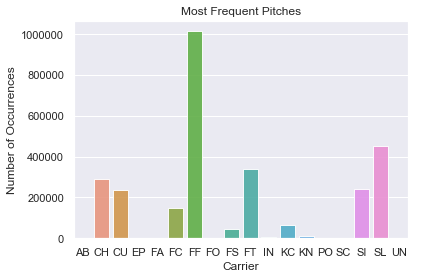

In [18]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
pitchCount = pitch['pitch_type'].value_counts()
sns.set(style="darkgrid")
sns.barplot(pitchCount.index, pitchCount.values, alpha=0.9)
plt.title('Most Frequent Pitches')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()

Right away, it is relevant to know that the four seam fastball is by far the most commonly used pitch in the data set. This is probably intuitive to most baseball players, as the four seam fastball is most pitchers' bread and butter.

### <center>3.2: Clustering </center>

The first thing we will do is use a dendrogram to decide how many clusters we want to use.

In [19]:
# use a relatively small sample for dendrogram

clusterSample = clusterDataNumerical.sample(n = 100)

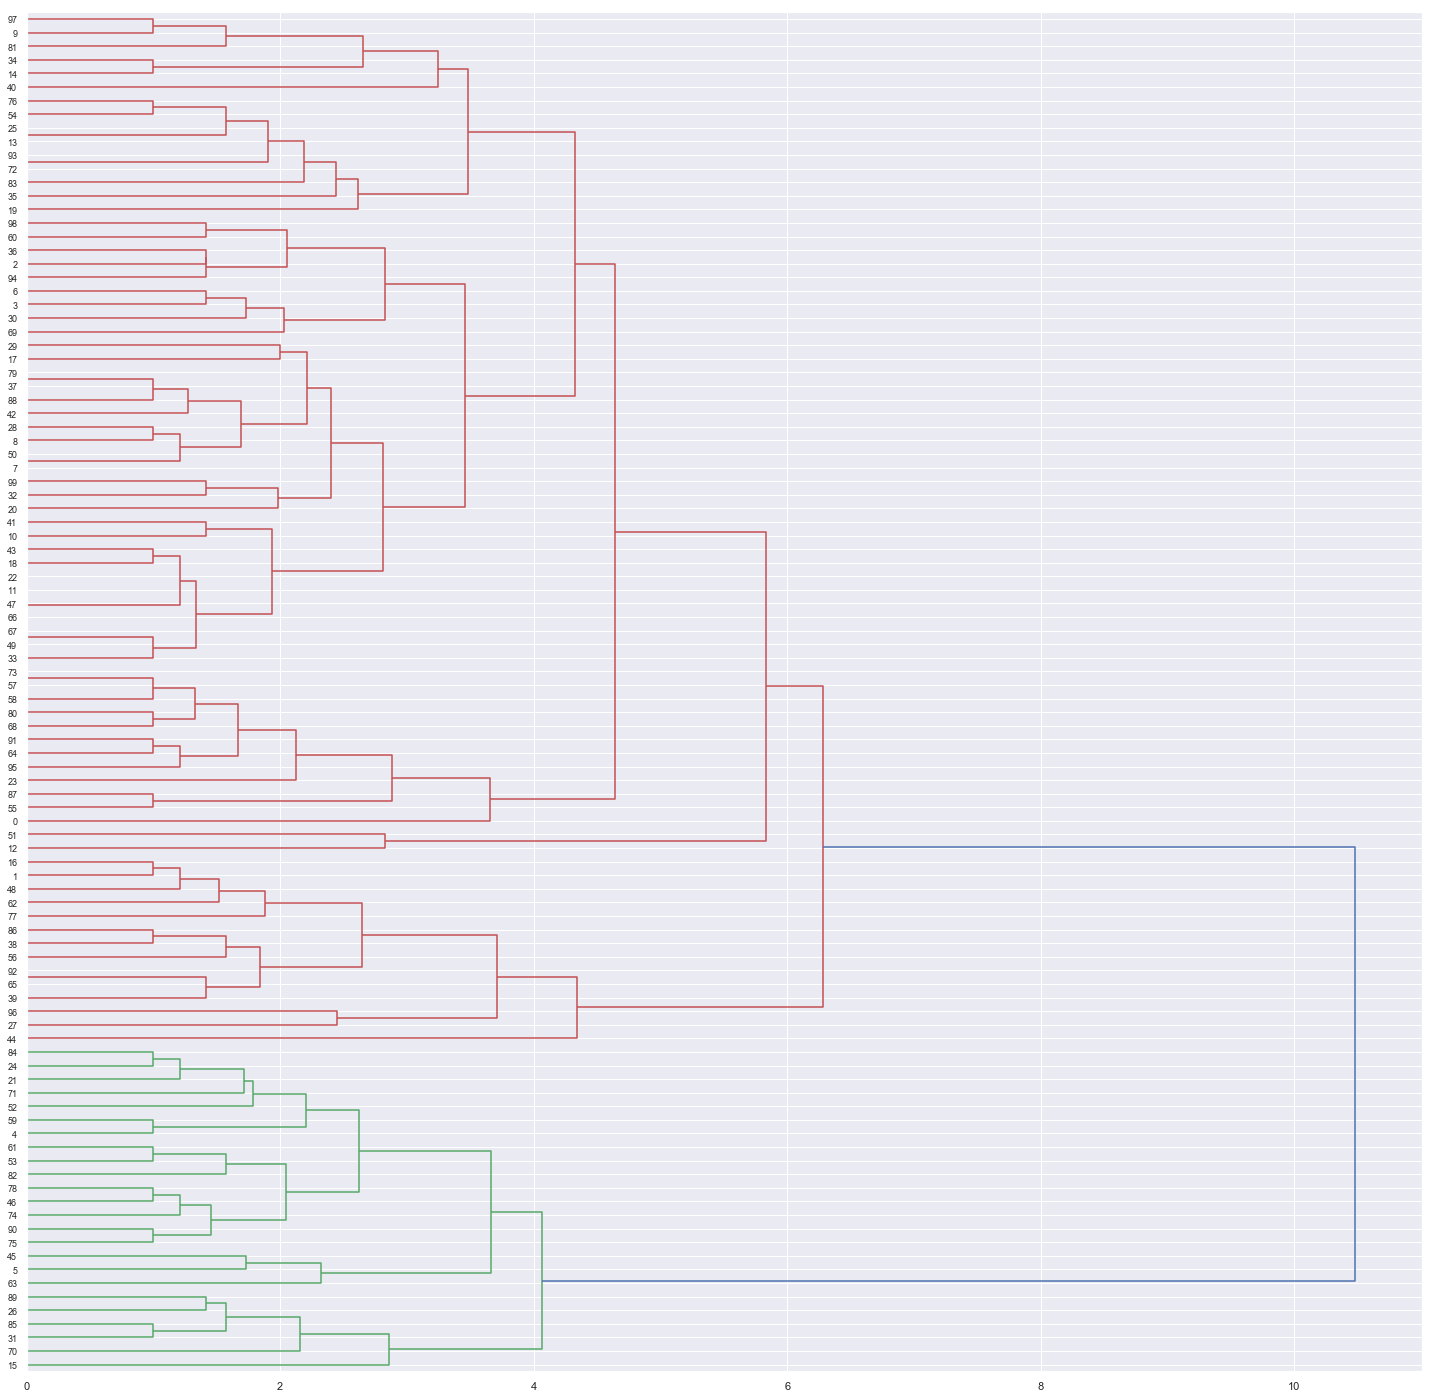

In [20]:
Z = linkage(clusterSample, 'average')
plt.figure(figsize=(25, 25))
D = dendrogram(Z=Z, orientation="right", leaf_font_size = 9)

The dendrogram seems to suggest two - three unique clusters. Lets move ahead and see how that works...

In [21]:
# reset the sample size to the number of rows

clusterSample = clusterDataNumerical.sample(n = 2867162)

In [22]:
k = 3
model = KMeans(n_clusters = k)
model.fit(clusterSample)
model.labels_

array([2, 2, 2, ..., 1, 2, 1], dtype=int32)

Remeber that we converted our pitch types into numerical data in our prep, so we're going to print our indicies and the pitches they coorespond to as a reminder:

In [23]:
for x in range(-1,17):
    print(x, pitchNames[x])

-1 UN
0 AB
1 CH
2 CU
3 EP
4 FA
5 FC
6 FF
7 FO
8 FS
9 FT
10 IN
11 KC
12 KN
13 PO
14 SC
15 SI
16 SL


In [24]:
cluster0 = clusterSample[model.labels_ == 0]
cluster1 = clusterSample[model.labels_ == 1]
cluster2 = clusterSample[model.labels_ == 2]

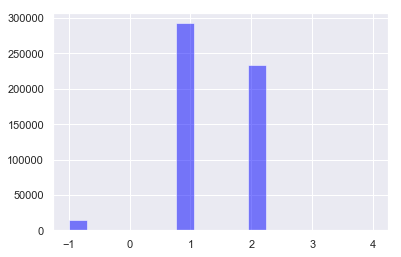

In [25]:
num_bins = 17
n, bins, patches = plt.hist(cluster0.pitch_type, num_bins, facecolor='blue', alpha=0.5)
plt.show()

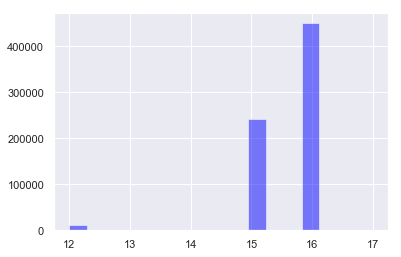

In [26]:
n, bins, patches = plt.hist(cluster1.pitch_type, num_bins, facecolor='blue', alpha=0.5)
plt.show()

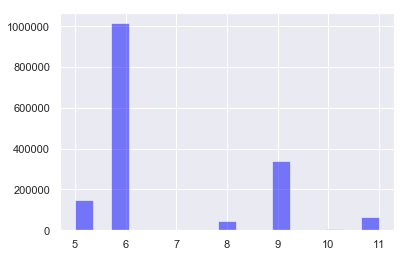

In [27]:
n, bins, patches = plt.hist(cluster2.pitch_type, num_bins, facecolor='blue', alpha=0.5)
plt.show()

These three histograms show us the composition of each cluster. Cluster 0 consists of mainly changeups and curveballs, cluster 1 of sliders and sinkers, and cluster 2 of mostly fastballs. Lets make a colormap to label these points intuitively:

In [28]:
colormap = np.array(["blue", "yellow", "red"])

## <center>3.3: Visualizing An At-Bat</center>

In order to get insight into the pattern in which pitches are thrown, we will visualize our points in a 3d space consisting of outs, our base rank metric, and pitch number. This makes the "floor" of our graph the game scenario, with the pitch count ascending vertically. This creates vertical columns where the color of the points represents the frequency in which the types of pitches in the cooresponding cluster are thrown. Since we used three clusters, I assigned them to the primary colors, and turned the depthshade parameter on the graphs on. This allows the colors to mix, creating a more nuanced graph. The color representations are as follows:

Primaries:
Blue: Cluster Zero, primarily Sinkers and Sliders
Yellow: Cluster One, primarily Fastballs and Fastball Variations
Red: Cluster Two, primarily Change-ups and Curveballs

As colors mix, the point represents a significant frequency of both the colors whose primary colors make up the displayed color. For example, a purple point would represent both the blue and red clusters, meaning the pitch may be a Sinker, Slider, Change-up or Curveball.

It is also worth noting that red, blue, and yellow together create a brownish hue. This would represent a significant frequency of all clusters.

(note: the cluster numbers do not always coorelate the same when you run this notebook. Refer to the histograms above for accuracy).

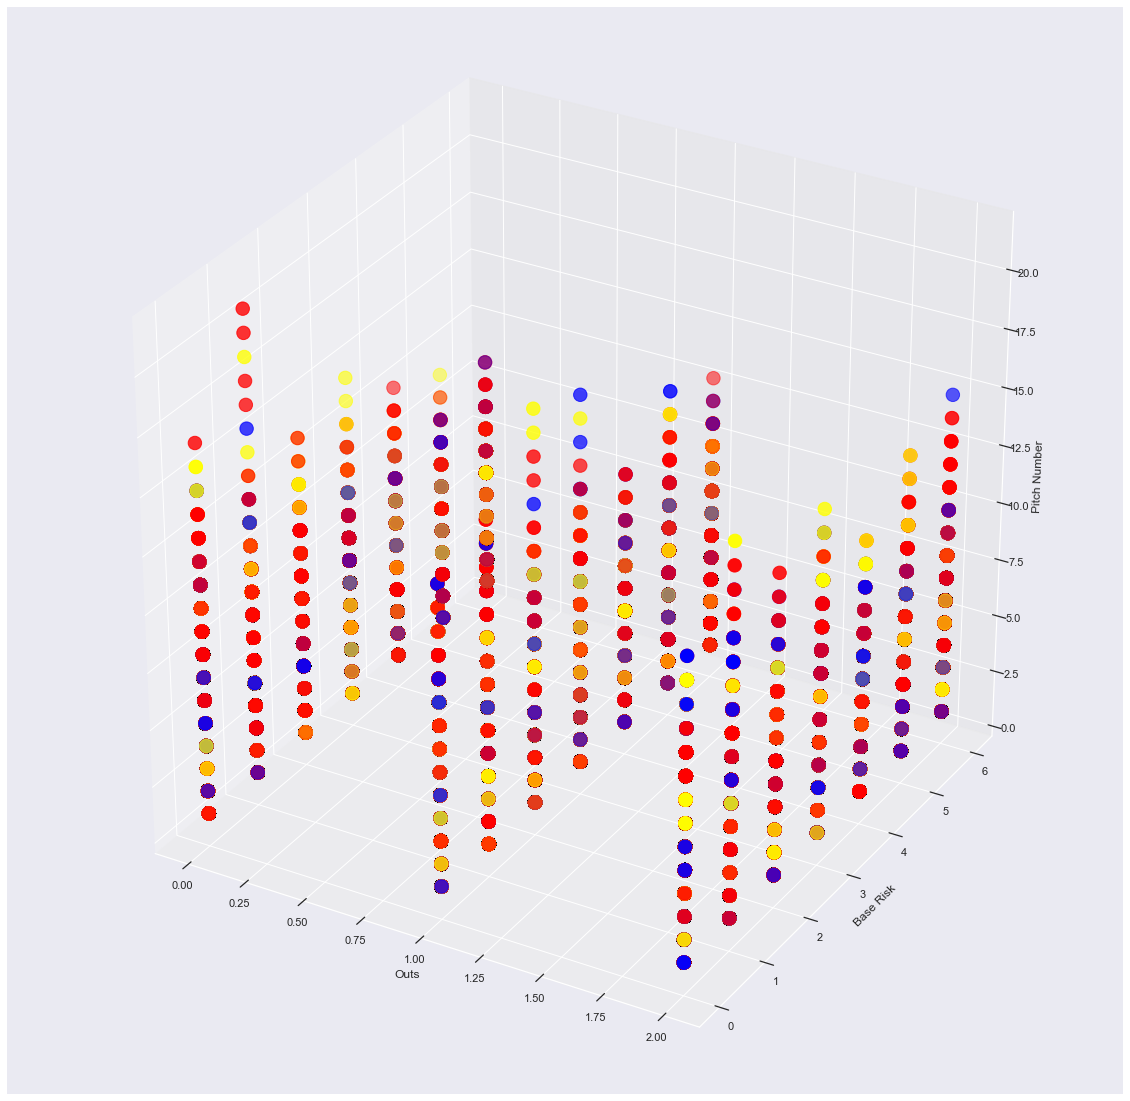

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = clusterSample.outs, ys =clusterSample.base_risk, zs = clusterSample.pitch_num, 
           s= 180, depthshade = True, c = colormap[model.labels_])
    
ax.set_xlabel('Outs')
ax.set_ylabel('Base Risk')
ax.set_zlabel('Pitch Number')

plt.show()

While pretty, the data is hard to interpret when every out is displayed, so we will break it out into three different graphs:

In [30]:
out0 = clusterSample[clusterSample.outs == 0]
out0Labels = model.labels_[clusterSample.outs == 0]

out1 = clusterSample[clusterSample.outs == 1]
out1Labels = model.labels_[clusterSample.outs == 1]

out2 = clusterSample[clusterSample.outs == 2]
out2Labels = model.labels_[clusterSample.outs == 2]

With zero outs:

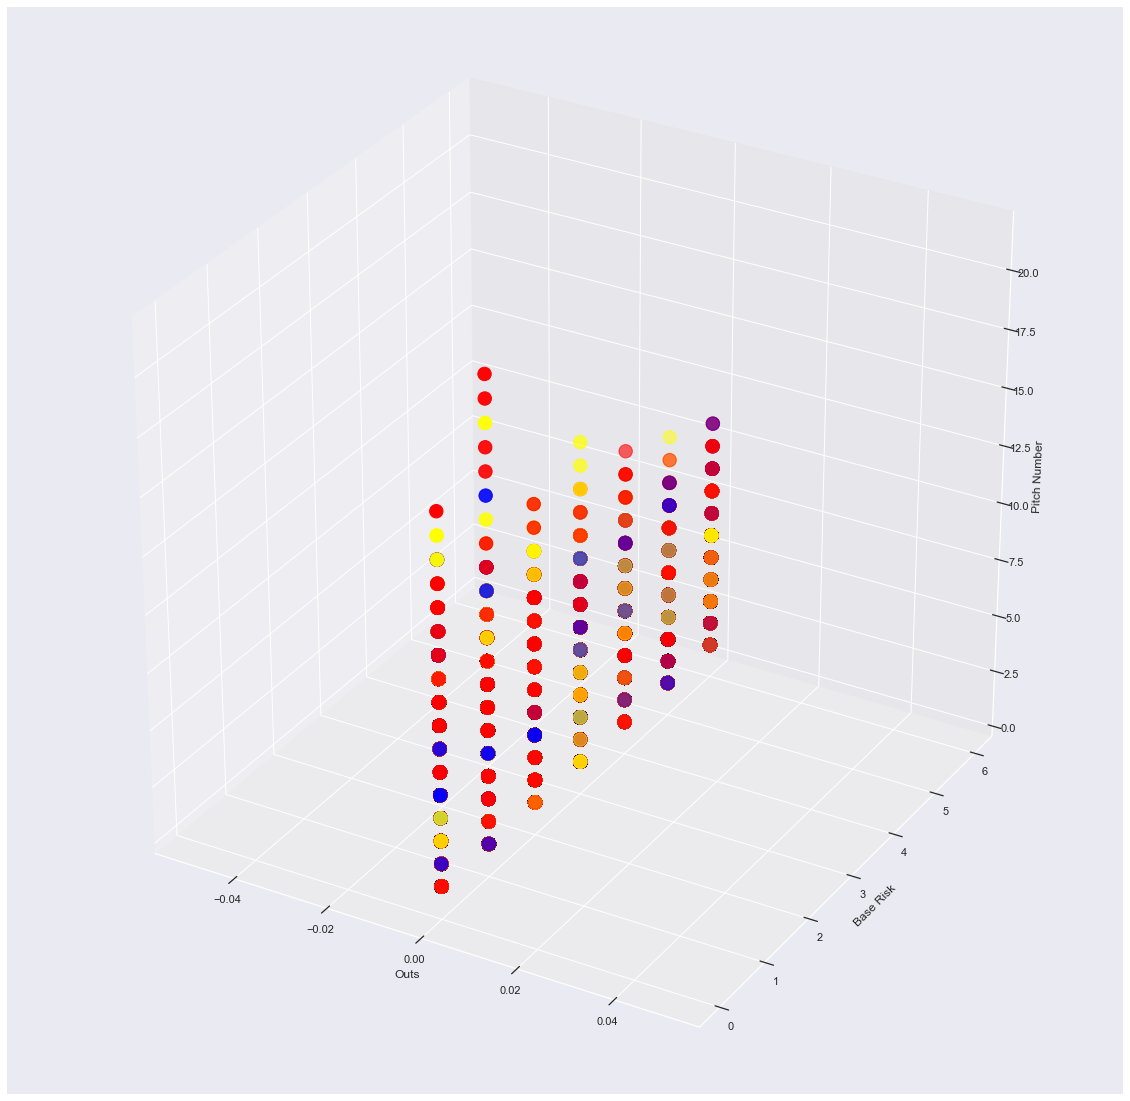

In [31]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = out0.outs, ys = out0.base_risk, zs = out0.pitch_num, 
           s= 180, depthshade = True, c = colormap[out0Labels])
    
ax.set_xlabel('Outs')
ax.set_ylabel('Base Risk')
ax.set_zlabel('Pitch Number')

plt.show()

With one out:

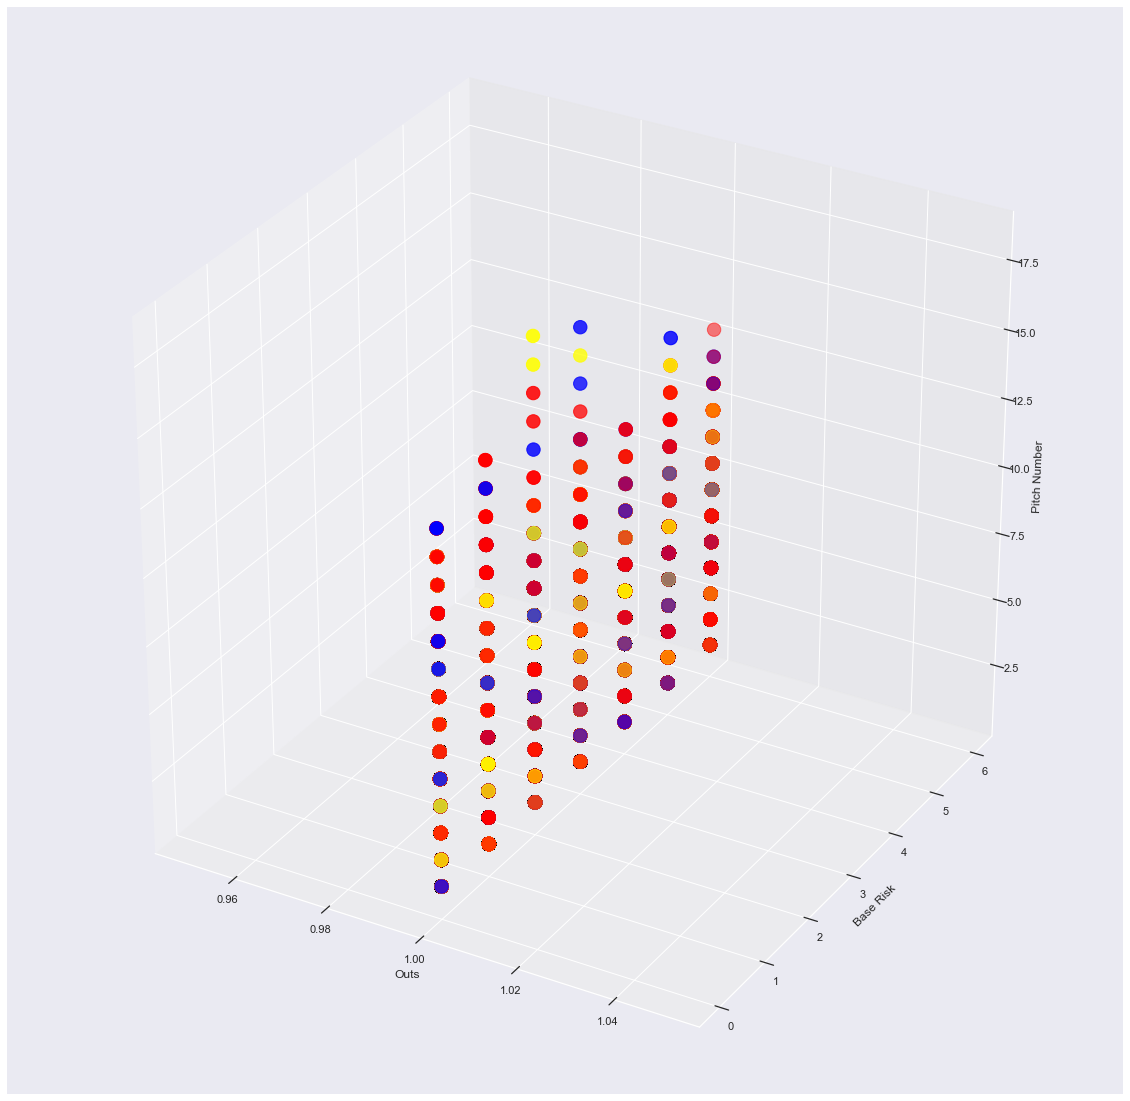

In [32]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = out1.outs, ys = out1.base_risk, zs = out1.pitch_num, 
           s= 180, depthshade = True, c = colormap[out1Labels])
    
ax.set_xlabel('Outs')
ax.set_ylabel('Base Risk')
ax.set_zlabel('Pitch Number')

plt.show()

With two outs:

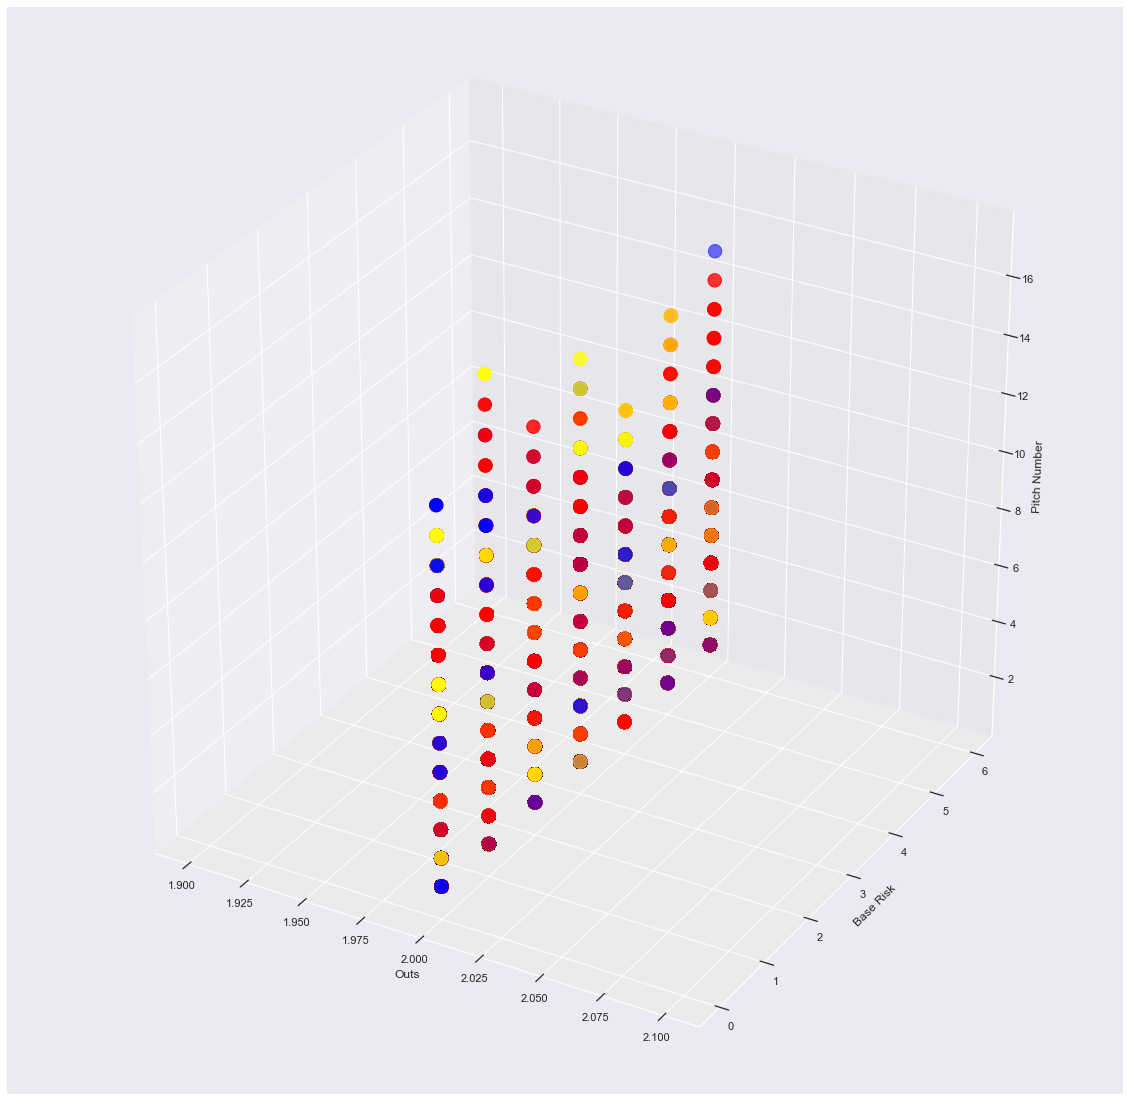

In [33]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = out2.outs, ys = out2.base_risk, zs = out2.pitch_num, 
           s= 180, depthshade = True, c = colormap[out2Labels])
    
ax.set_xlabel('Outs')
ax.set_ylabel('Base Risk')
ax.set_zlabel('Pitch Number')

plt.show()

This type of analysis is useful for analyzing trend for the entire league. Two notable things here are that pitch count (or, the height of the columns) seems to increase as the number of outs increase. It also seems that the "in between" points (browns, oranges, magentas, etc) seem to increase as the base risk increases, implying that pitchers put more effort in variation when there are a lot of runners on base.

## <center>3.4: Visualizing At-Bats for A Single Pitcher</center>

A team could use this pitching data to draw broad conclusions for the entire league, but a more practical application would be to do this kind of analysis for a single pitcher. To simulate this, we will take a small subset of our data and treat it as if it were a pitcher.

Baseball seasons are 162 games long, and pitchers will often be pulled after 100 pitches to prevent injury. Furthermore, a team often has at least two pitchers. For this simulation, we will assume a pitcher averages $ 100 * (162/2) $ pitcher per season, or 8100 pitches

In [34]:
# create a sample pitcher with 8100 rows
clusterSample['clusterID'] = model.labels_

np.random.seed(seed = 170)

rows = np.random.choice(clusterSample.index.values, 8100)
simPitcher = clusterSample.loc[rows]

simPitcher = simPitcher[simPitcher.outs == 1]

simPitcher.head()

,outs,pitch_num,base_risk,pitch_type,s_count,clusterID
690138,1,3,0,9,1,2
1793303,1,1,0,6,0,2
2010204,1,2,0,16,1,1
1469128,1,5,2,5,2,2
2417541,1,5,0,6,2,2


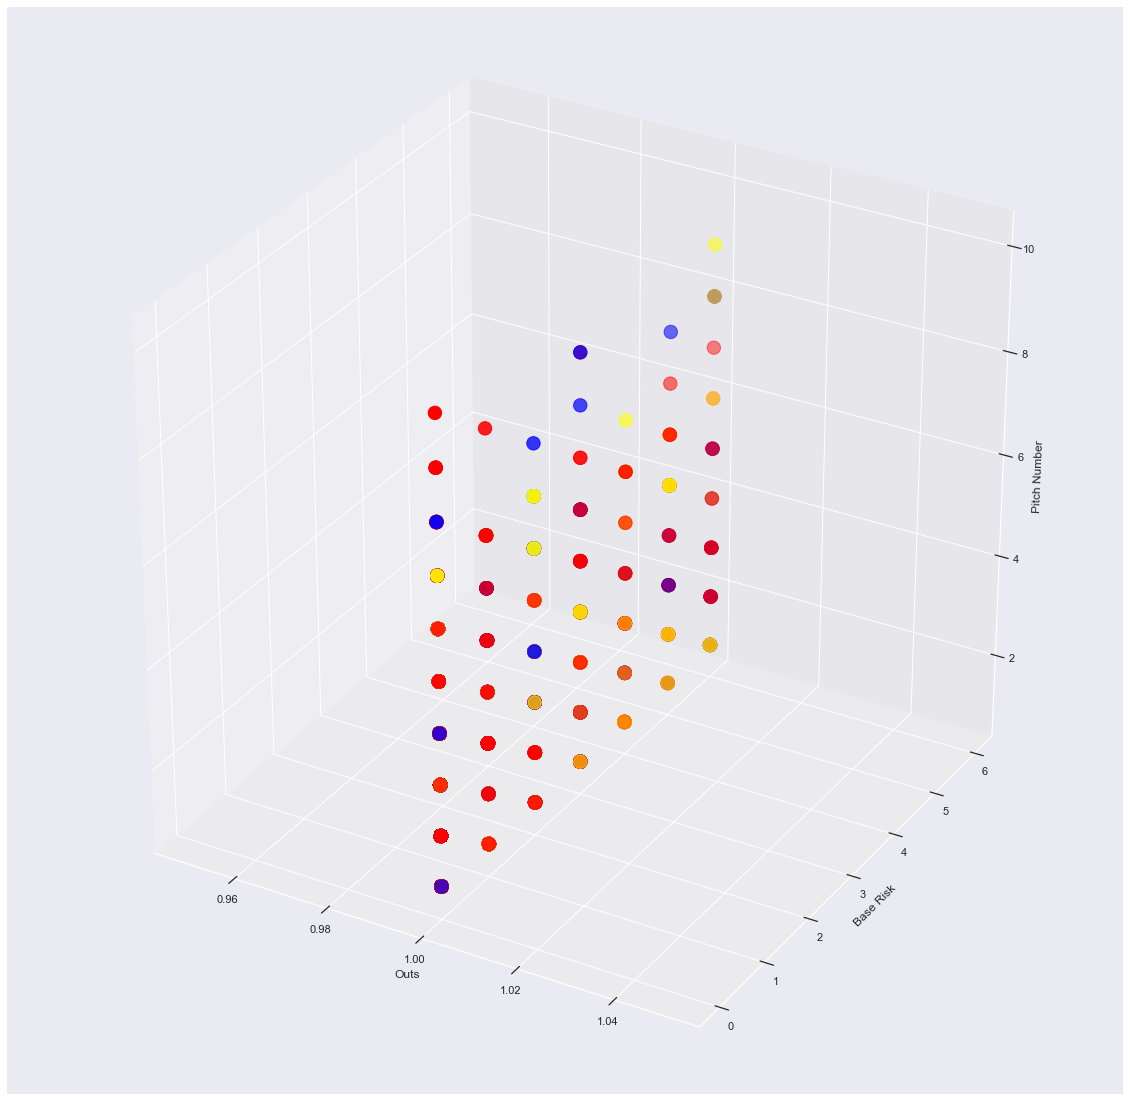

In [35]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = simPitcher.outs, ys = simPitcher.base_risk, zs = simPitcher.pitch_num, 
           s= 180, depthshade = True, c = colormap[simPitcher["clusterID"]])
    
ax.set_xlabel('Outs')
ax.set_ylabel('Base Risk')
ax.set_zlabel('Pitch Number')

plt.show()

From this graph, we can extract some key things about this pitcher. First, the pitcher likes to throw curveballs in the middle of the count when there are not many people on base. Second, following the trend from the graphs of the entire league, this pitcher tends to have more brown points when there are more people on base. Finally, this pitcher seems to like to finish at-bats with fastballs, with yellow points being the top point in 4/7 columns.

## <center>4: Conclusion</center>

In conclusion, we were able to cluster data points in such a way that successful placed them into three buckets that contained related pitches. Using this data, we were able to graph it in such a way that allows analysis of the trend of pitches over the course of an inning, both for all pitchers and pitches in the MLB, or the more granular approach of analyzing a single pitcher. This type of analysis can act as a double-edged sword. For a team at-bat, a batter could be handed an iPad with a visualization of the current pitcher's habits to prepare them for success when they are up. The inverse is true of pitchers, where a coach may inform them of their own habits so they can intentionally buck them, keeping the batter on their toes. 